# Propagation of Uncertainty

## Introduction and background information

The classical Stefan problem, named after the Slovenian physicist Josef Stefan, refers to a boundary value problem for a Partial Differential Equations (PDE) system. It describes the evolution of the boundary between two phases subject to a change in their phase. For instance, to determine how an ice layer grows as a function of time, given the constraint that the temperature of air ($T_{air}$) is constant, smaller than the freezing temperature $T_{fr}$ and everywhere the same.

Using this problem, we can model ice growth as:

$$
H^2_{ice}-H^2_{ice,0} = \frac{2 k_{ice}}{\rho_{ice} \cdot l}\int{(T_s-T_{fr})}dt
$$

where 
- $H_{ice}$ is the thickness of the ice at a given time $t$, 
- $H_{ice,0}$ is the thickness of the ice at time $t=0$, 
- $k_{ice}=2.2W/(K \cdot m)$ is the thermal conductivity of ice, 
- $\rho_{ice}=917 kg/m^3$ is the density of ice, 
- $l = 333.4 kJ/kg$ is the latent heat of fusion, 
- $T_s$ is equal to the temperature of the air, 
- $T_{fr}=273K$ is the freezing temperature of water.

We assume the temperature remains stable during a period of a five days, therefore
$$
H_{ice} = \sqrt{\frac{2 k_{ice}}{\rho_{ice} l}\Delta T \Delta t+H^2_{ice,0}}
$$

where $\Delta T = |T_s-T_{fr}|$ and $\frac{2 k_{ice}}{\rho_{ice} l} \approx 1.44 \cdot 10^{-8} \ m^2/K s$.

---
**Inputs and main assumptions**

- Based on the ice measurement samples, 
  - the mean thickness value is $ \mu_{H_0} = 0.20 \;m$ 
  - the standard deviation of thickness is $\sigma_{H_0} = 0.03 \;m$.

- Based on the forecast during the next 5 days, 
  - the mean air temperature is $\mu_T = 263 \;K$
  - the standard deviation of the temperature is $\sigma_T = 4 \;K$.

- The rest of the variables are deterministic.

- The ice thickness and the predicted temperature are independent random variables.

**GOALS: uncertainty propagation via Taylor approximation vs Monte Carlo simulations**

Note: we are interested in the increment of temperature $|T_s-T_{fr}|$, where the mean is assumed to be $\mu_{iT} = |263-273| = 10 \;K$ with standard deviation given by $\sigma_{iT} = 4 \;K$.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import probplot

plt.rcParams.update({'font.size': 14})

### Some first checks

Below you find a definition of the function providing the ice thinkness at time $t$. This can be useful to debug your code, or to get an understanding for the function of random variables.

In [8]:
def stefan(constant, H0, Ts, Tfr, time):
    return np.sqrt(constant*time*abs(Ts-Tfr) + H0**2)

In [9]:
print('Ice thickness: ' +
      f'{stefan(1.44*10**(-8), 0.15, 261, 273, 5*24*3600):.3f} m')

Ice thickness: 0.312 m


## Part 1: Transforming random variables

We look at a transformation of random variables by
1. **Taylor approximation**, so we define `H_taylor()` function to find mean and standard deviation of the linearized function of random variables;
2. **Monte Carlo simulations**, with the `H_ice` function to find the distribution (+ fitting moments) after propagating samples randomly generated.

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 1.1:**

Write out the analytical equations on paper, then complete the two functions in the cell below.
    
</p>
</div>

In [ ]:
def H_taylor(mu_H0, mu_iT, sigma_H0, sigma_iT):
    """ Taylor series approximation of mean and std of H"""
    
    # # Write your own preliminary variables here
    # YOUR_CODE_HERE # Probably more than one line

    mu_H = ### YOUR CODE HERE ###
    sigma_H = ### YOUR CODE HERE ###
    
    return mu_H, sigma_H

def samples_plot(N, mu_H0, mu_iT, sigma_H0, sigma_iT):
    """Generate samples and plots for V
    
    Compares the approximated Normal distribution of V to numerically
    approximated distribution, found by sampling from the input
    distributions.
    
    Return: a plot and the mean and std dev of simulated values of H_ice.
    """
    # H0_samples = ### YOUR CODE HERE ###
    # iT_samples = ### YOUR CODE HERE ###


    # negative values of ice thickness not physically possible
    count_negative_iT = sum(iT_samples < 0)
    if count_negative_iT > 0:
        iT_samples[iT_samples < 0] = 0
        print(f'Number of iT samples adjusted to 0: {count_negative_iT} '+
              f'({count_negative_iT/N*100:.1f}% of N)')
    
    # h_samples = ### YOUR CODE HERE ###
    # mu_H = ### YOUR CODE HERE ###
    # sigma_H = ### YOUR CODE HERE ###

    
    # Plot histogram
    xmin = 0.0
    xmax = 0.5
    x = np.linspace(xmin, xmax, 100)
    fig, ax = plt.subplots(1, 2, figsize = (16, 6))

    # ax[0].hist(### YOUR CODE HERE ###,
    #            bins = 40, density = True,
    #            edgecolor='black', linewidth=1.2, 
    #            label = 'Empirical PDF of ${H_{ice}}$')

    # Add normal pdf in same figure
    # ax[0].plot(x, ### YOUR CODE HERE ###, color = 'black',
    #            lw = 2.5, label='Normal PDF')
    
    # Add probability plot in right-side panel
    # probplot(### YOUR CODE HERE ###, dist = norm, fit = True, plot = ax[1])
    
    
    return mu_H, sigma_H, h_samples

In [5]:
def H_taylor(mu_H0, mu_iT, sigma_H0, sigma_iT):
    """ Taylor series approximation of mean and std of H"""

    constant = 1.44*10**(-8)
    time = 5*24*3600
    
    dhdiT = ((constant*time*mu_iT + mu_H0**2)**(-0.5))*constant/2*time
    dhdH0 = ((constant*time*mu_iT + mu_H0**2)**(-0.5))*mu_H0
    
    dhdiT_2 = -((constant/2*time)**2)*(constant*time*mu_iT+mu_H0**2)**(-1.5)
    dhdH0_2 = (((constant*time*mu_iT + mu_H0**2)**(-0.5)) - 
              mu_H0**2*(constant*time*mu_iT + mu_H0**2)**(-1.5))

    mu_H_0 = np.sqrt(constant*time*mu_iT + mu_H0**2)
    mu_H = mu_H_0 + 0.5*dhdiT_2*sigma_iT**2 + 0.5*dhdH0_2*sigma_H0**2
    
    var_H = (dhdiT**2)*sigma_iT**2 + (dhdH0**2)*sigma_H0**2
    sigma_H = np.sqrt(var_H)
    
    return mu_H, sigma_H

def samples_plot(N, mu_H0, mu_iT, sigma_H0, sigma_iT):
    """Generate samples and plots for V
    
    Compares the approximated Normal distribution of V to numerically
    approximated distribution, found by sampling from the input
    distributions.
    
    Return: a plot and the mean and std dev of simulated values of H_ice.
    """
    # Generate samples
    H0_samples = np.random.normal(mu_H0, sigma_H0, N)
    iT_samples = np.random.normal(mu_iT, sigma_iT, N)

    # negative values of ice thickness not physically possible
    count_negative_iT = sum(iT_samples < 0)
    if count_negative_iT > 0:
        iT_samples[iT_samples < 0] = 0
        print(f'Number of iT samples adjusted to 0: {count_negative_iT} '+
              f'({count_negative_iT/N*100:.1f}% of N)')
    
    constant = 1.44*10**(-8)
    time = 5*24*3600
    h_samples = np.sqrt(constant*time*iT_samples + H0_samples**2)
    mu_H = np.mean(h_samples)
    sigma_H = np.std(h_samples)
    
    # Plot histogram
    xmin = 0.0
    xmax = 0.5
    x = np.linspace(xmin, xmax, 100)
    fig, ax = plt.subplots(1, 2, figsize = (16, 6))

    ax[0].hist(h_samples,
               bins = 40, density = True,
               edgecolor='black', linewidth=1.2, 
               label = 'Empirical PDF of ${H_{ice}}$')
    
    # Add normal pdf in same figure

    mu_H_taylor, sigma_H_taylor = H_taylor(mu_H0, mu_iT, sigma_H0, sigma_iT)
    ax[0].plot(x, norm.pdf(x, mu_H_taylor, sigma_H_taylor), color = 'black',
               lw = 2.5, label='Normal PDF')
    ax[0].set_xlim(xmin, xmax)
    ax[0].legend()
    ax[0].set_xlabel('${H_{ice} [m]}$')
    ax[0].set_ylabel('Density')
    ax[0].set_title(f'Simulation with {N} simulated realizations'
                    + '\n' + f'mean = {mu_H:.3e}' 
                    f'm and std = {sigma_H:.3e} m')
    
    # Add probability plot in right-side panel
    probplot(h_samples, dist = norm, fit = True, plot = ax[1])
    ax[1].legend(['Generated samples', 'Normal fit'])
    ax[1].get_lines()[1].set_linewidth(2.5)
    plt.show()
    
    return mu_H, sigma_H, h_samples

## Part 2: Mean and Variance propagation laws

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 2.1:**
    
Use the functions defined in Task 1 to compute the mean and standard deviation of the linearized function of random variables, and compare the distribution defined by this analytical result to the distribution of $H_{ice}$ found using Monte Carlo simulations.
    
</p>
</div>

Now we can compute the mean $\mu_H$ and standard deviation $\sigma_H$ as function of:  
- $\mu_T = 10 \; \mathrm{K}$ and $\sigma_T = 4 \; \mathrm{K}$
- $\mu_{H_0} = 0.20 \; \mathrm{m}$ and $\sigma_{H_0} = 0.03 \; \mathrm{m}$

In [ ]:
mu_iT = 10
sigma_iT = 4
mu_H0 = 0.20
sigma_H0 = 0.03
N = 10000

# Propagated Mean-Variance via Taylor approximation
mu_H, sigma_H = ### YOUR CODE HERE ###

# Propagated Mean-Variance via MC simulations
mu_H_simulated, sigma_H_simulated, _ = ### YOUR CODE HERE ###

print('\n\nMean and standard deviation of linearized function:')
print('  \N{GREEK SMALL LETTER MU}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H}=',
      f'{mu_H:.3f}', 'm')
print('  \N{GREEK SMALL LETTER SIGMA}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H}=',
      f'{sigma_H:.3f}', 'm')

print('\n\nMean and standard deviation of simulated distribution:')
print('  \N{GREEK SMALL LETTER MU}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H} =',
      f'{mu_H_simulated:.3f}', 'm')
print('  \N{GREEK SMALL LETTER SIGMA}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H}=',
      f'{sigma_H_simulated:.3f}', 'm')
print('\n')

Number of iT samples adjusted to 0: 51 (0.5% of N)


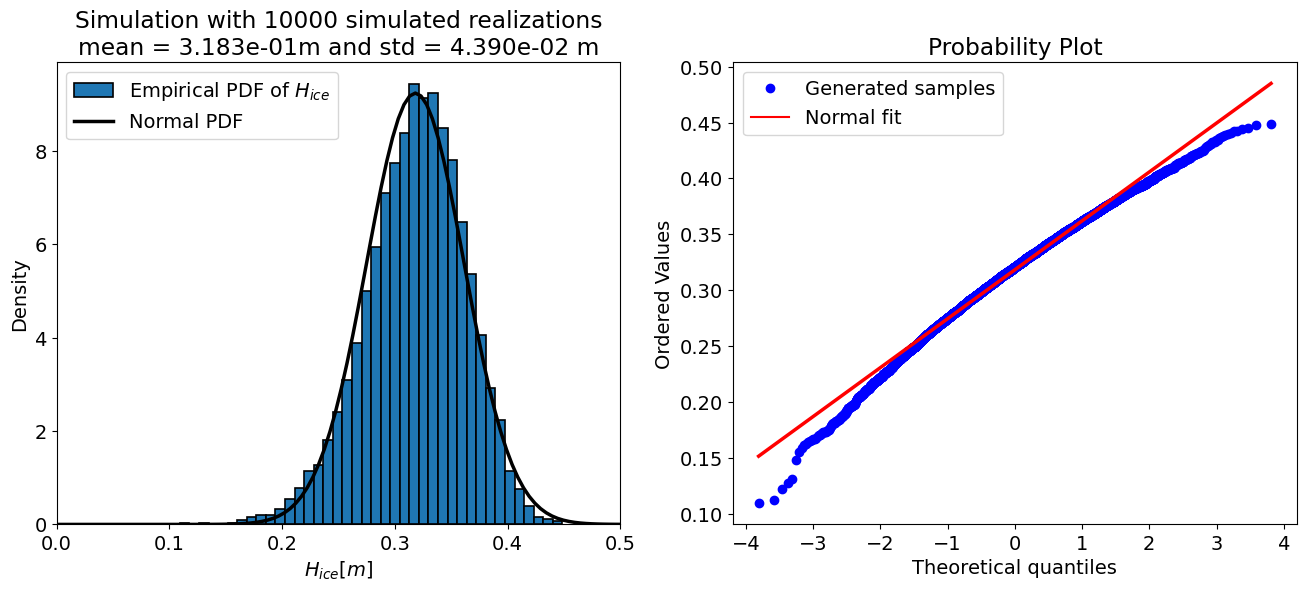



Mean and standard deviation of linearized function:
  μ ₕ= 0.318 m
  σ ₕ= 0.043 m


Mean and standard deviation of simulated distribution:
  μ ₕ = 0.318 m
  σ ₕ= 0.044 m




In [6]:
mu_iT = 10
sigma_iT = 4
mu_H0 = 0.20
sigma_H0 = 0.03
N = 10000

# Propagated Mean-Variance via Taylor approximation
mu_H, sigma_H = H_taylor(mu_H0, mu_iT, sigma_H0, sigma_iT)

# Propagated Mean-Variance via MC simulations
mu_H_simulated, sigma_H_simulated, _ = samples_plot(N,
                                                    mu_H0, mu_iT,
                                                    sigma_H0, sigma_iT)

print('\n\nMean and standard deviation of linearized function:')
print('  \N{GREEK SMALL LETTER MU}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H}=',
      f'{mu_H:.3f}', 'm')
print('  \N{GREEK SMALL LETTER SIGMA}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H}=',
      f'{sigma_H:.3f}', 'm')

print('\n\nMean and standard deviation of simulated distribution:')
print('  \N{GREEK SMALL LETTER MU}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H} =',
      f'{mu_H_simulated:.3f}', 'm')
print('  \N{GREEK SMALL LETTER SIGMA}',
        '\N{LATIN SUBSCRIPT SMALL LETTER H}=',
      f'{sigma_H_simulated:.3f}', 'm')
print('\n')

**NOTE** Recall that the right-hand plot above (and below) is by default labeled "theoretical quantiles" but in fact it is the quantile value while the y-axis contains the ordered values of the output variable, therefore the ice thickness.

## Part 3: Monte Carlo simulations - varying the sample size

The "accuracy" of a Monte Carlo simulation depends on the number of the samples, therefore the code cell below sets up a loop and prints the output of the uncertainty propagation for a few different sample sizes. Take a look at the results and see how they change.

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 3.1:**
    
The code cell below can be used for your answer to one of the questions in the Report, where you are asked to consider the "inaccurate" values that might be produced by this model.
    
</p>
</div>

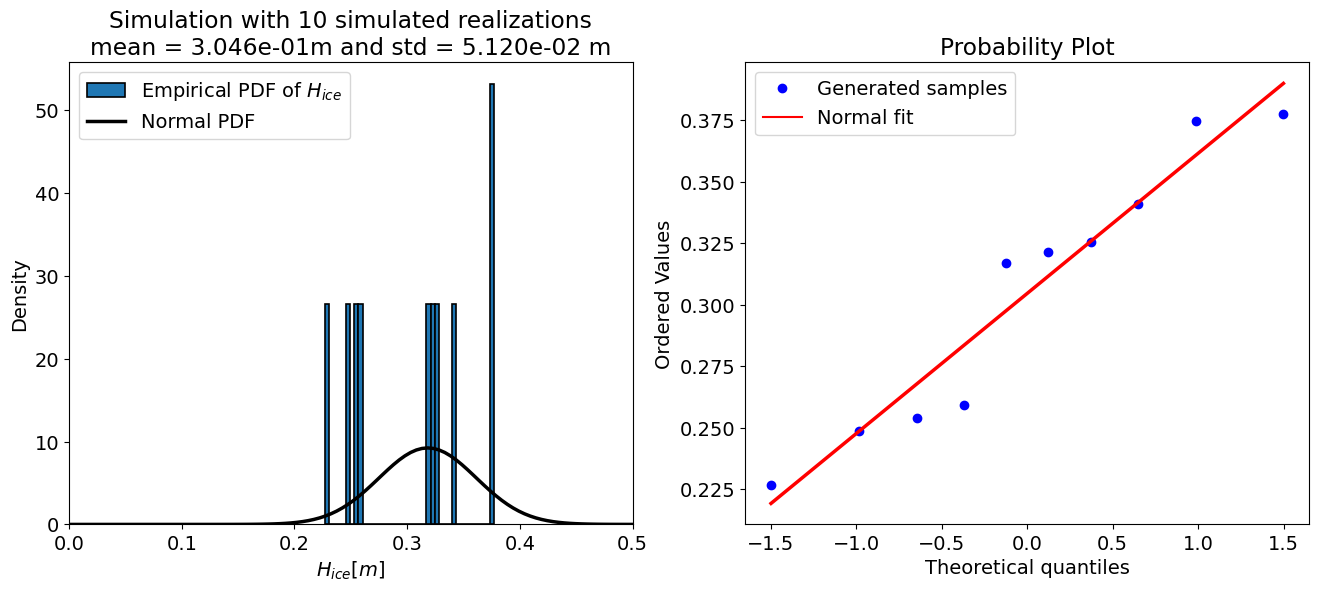

For N = 10 samples:
    mean = 0.305 m
    std = 0.051 m



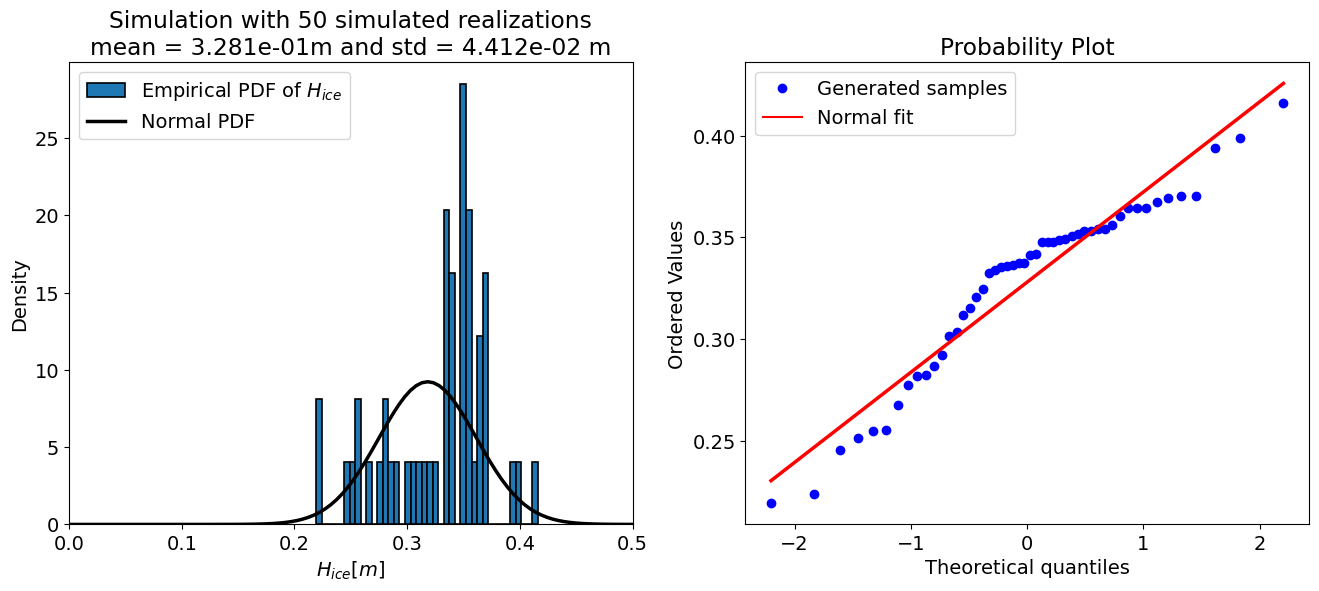

For N = 50 samples:
    mean = 0.328 m
    std = 0.044 m



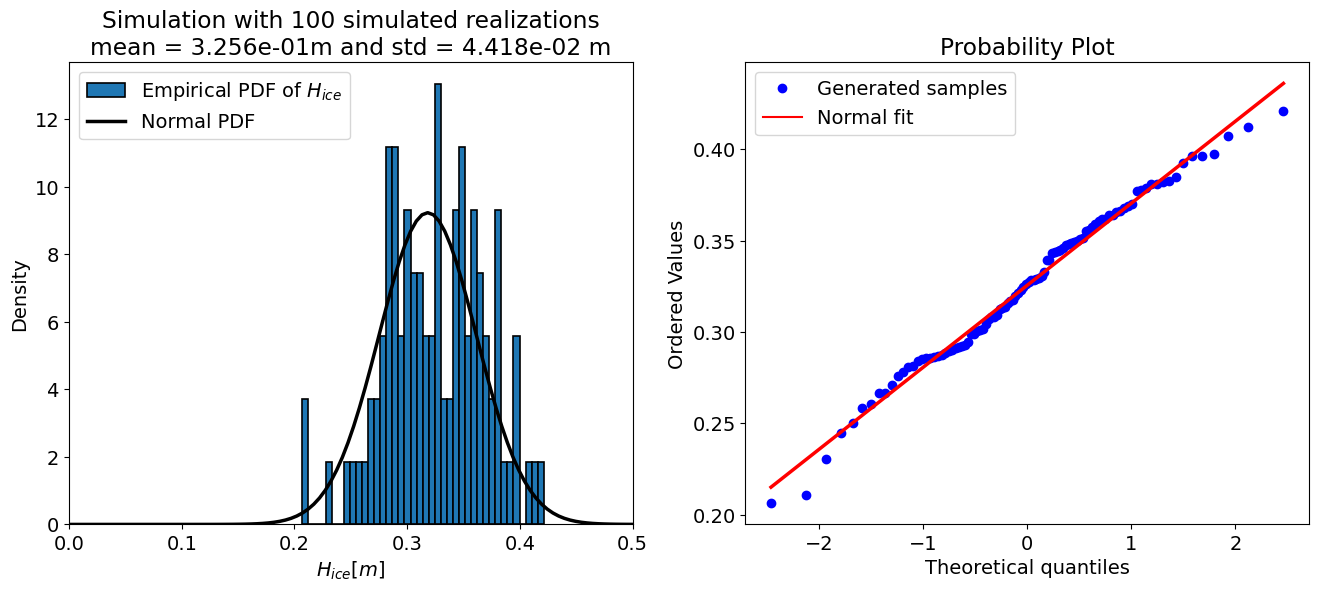

For N = 100 samples:
    mean = 0.326 m
    std = 0.044 m

Number of iT samples adjusted to 0: 3 (0.6% of N)


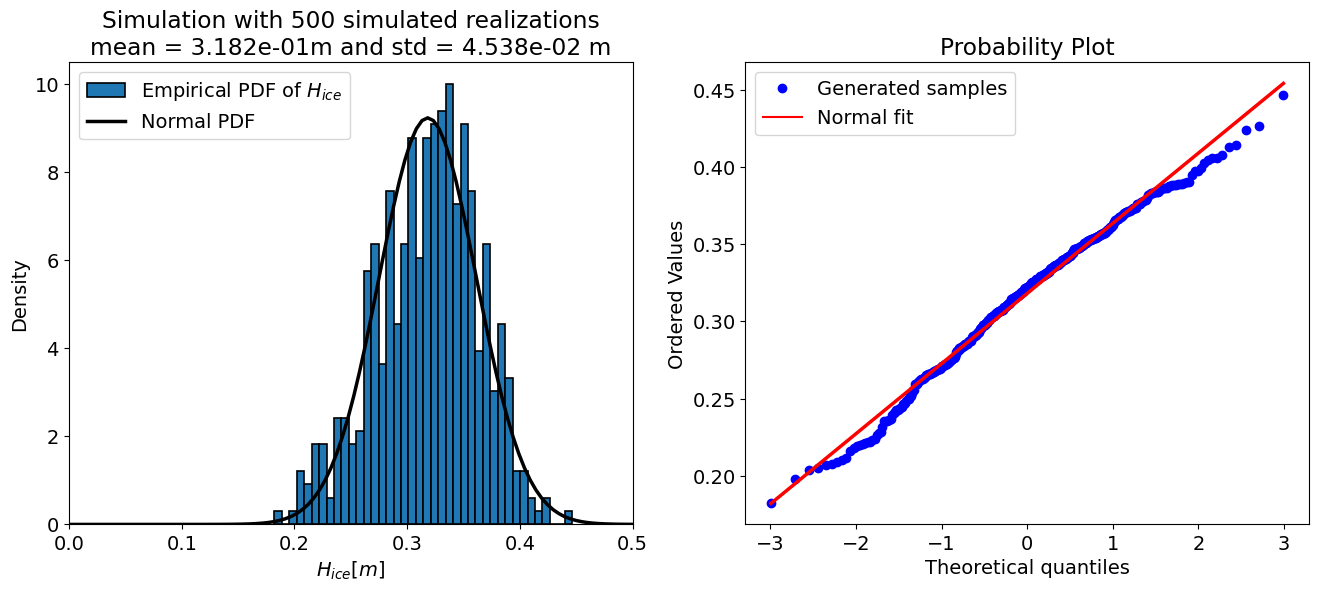

For N = 500 samples:
    mean = 0.318 m
    std = 0.045 m

Number of iT samples adjusted to 0: 55 (0.5% of N)


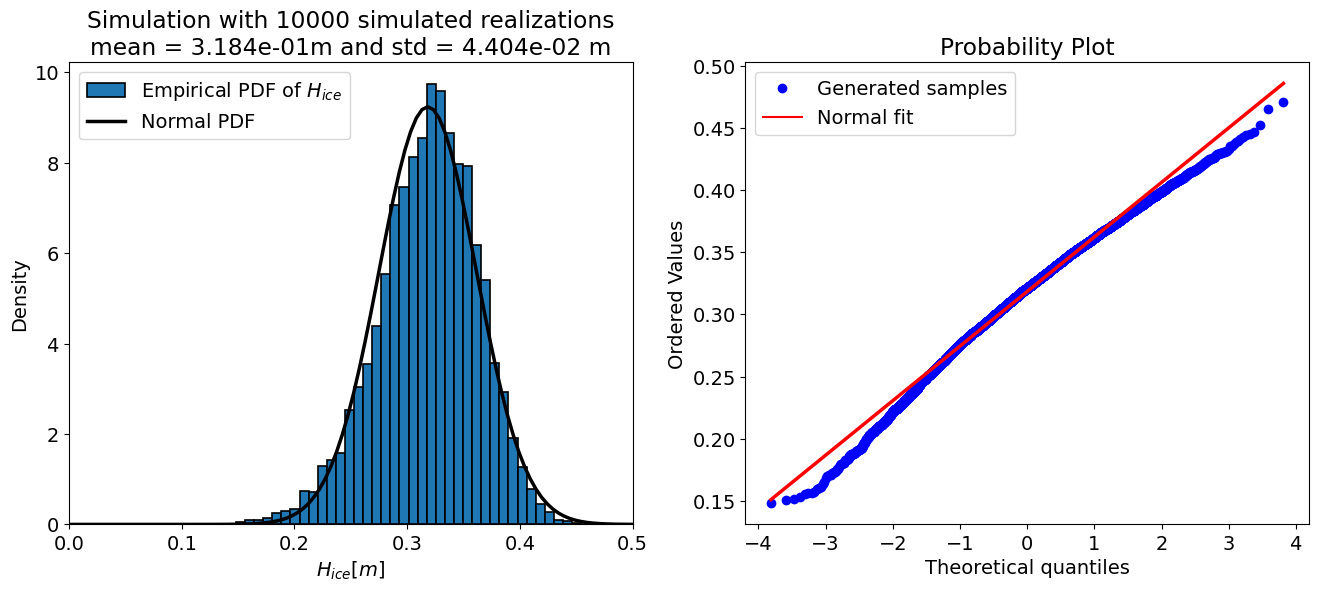

For N = 10000 samples:
    mean = 0.318 m
    std = 0.044 m

Number of iT samples adjusted to 0: 294 (0.6% of N)


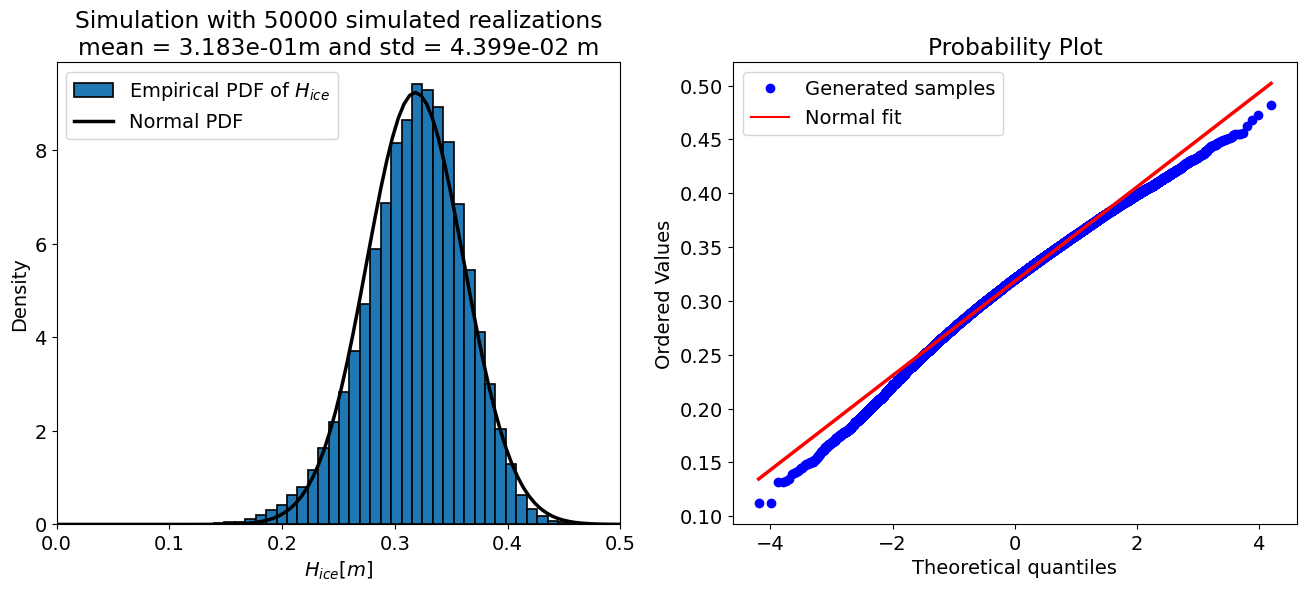

For N = 50000 samples:
    mean = 0.318 m
    std = 0.044 m

Number of iT samples adjusted to 0: 582 (0.6% of N)


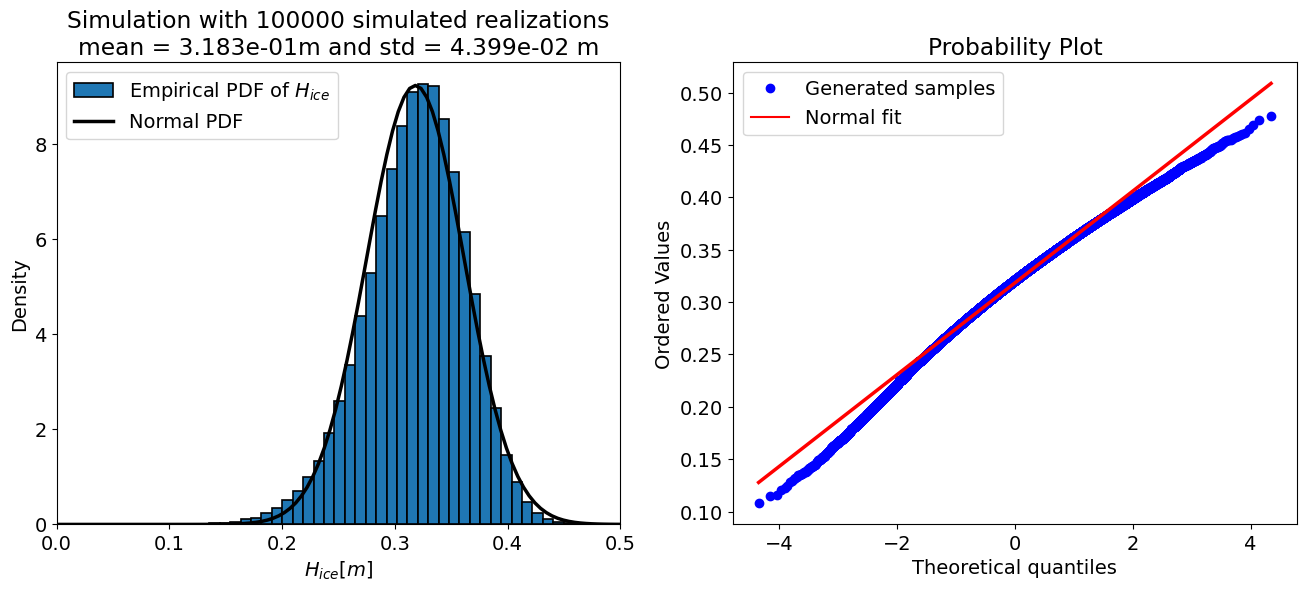

For N = 100000 samples:
    mean = 0.318 m
    std = 0.044 m



In [12]:
for N in [10, 50, 100, 500, 10000, 50000, 100000]:
    mu_H_simulated, sigma_H_simulated, h_samp = samples_plot(N,
                                                             mu_H0,
                                                             mu_iT,
                                                             sigma_H0,
                                                             sigma_iT)
    print(f'For N = {N} samples:')
    print(f'    mean = {mu_H_simulated:.3f} m')
    print(f'    std = {sigma_H_simulated:.3f} m\n')

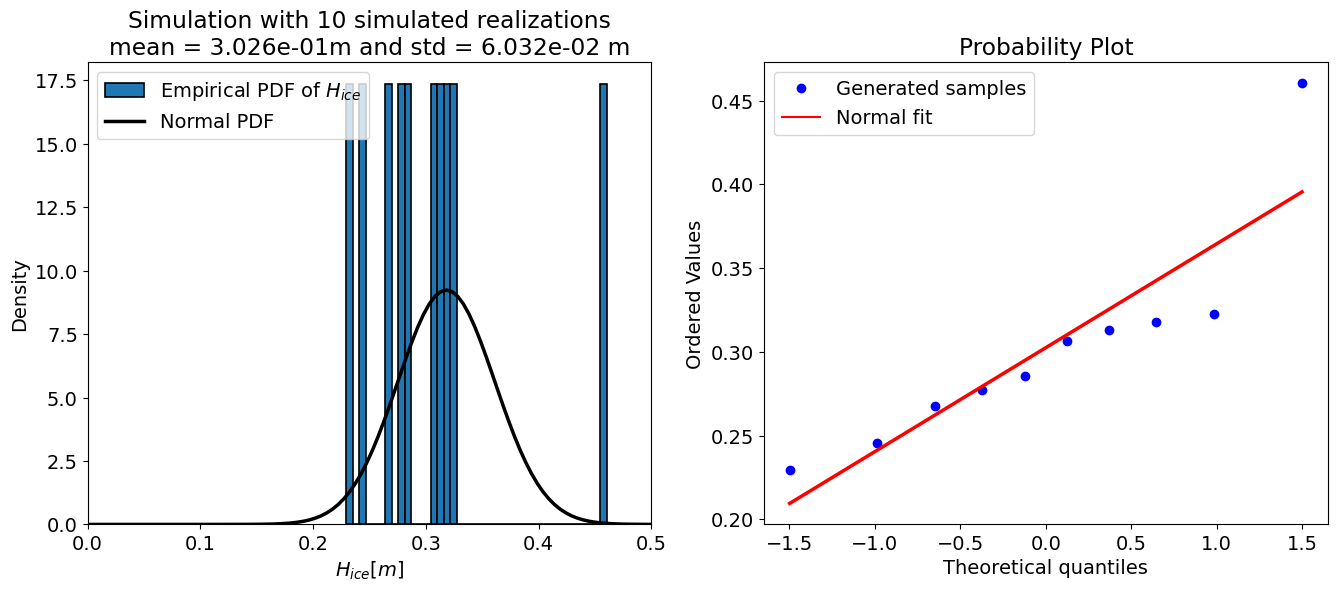

For N = 10 samples:
    mean = 0.303 m
    std = 0.060 m

Number of iT samples adjusted to 0: 1 (2.0% of N)


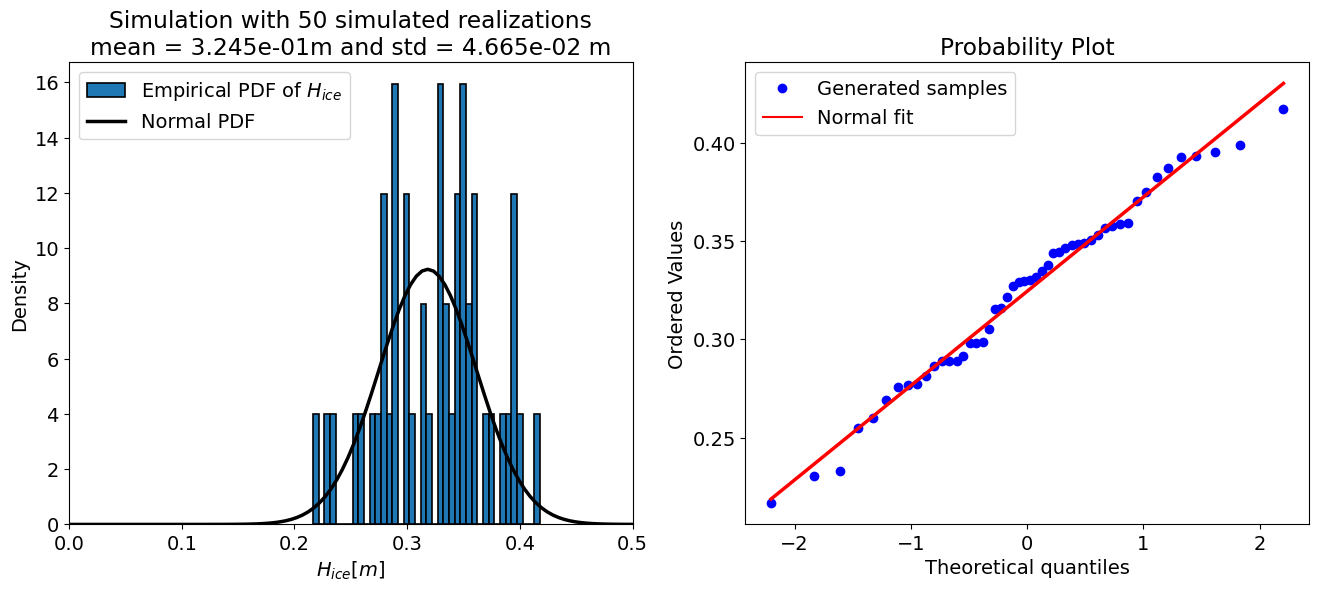

For N = 50 samples:
    mean = 0.325 m
    std = 0.047 m

Number of iT samples adjusted to 0: 1 (1.0% of N)


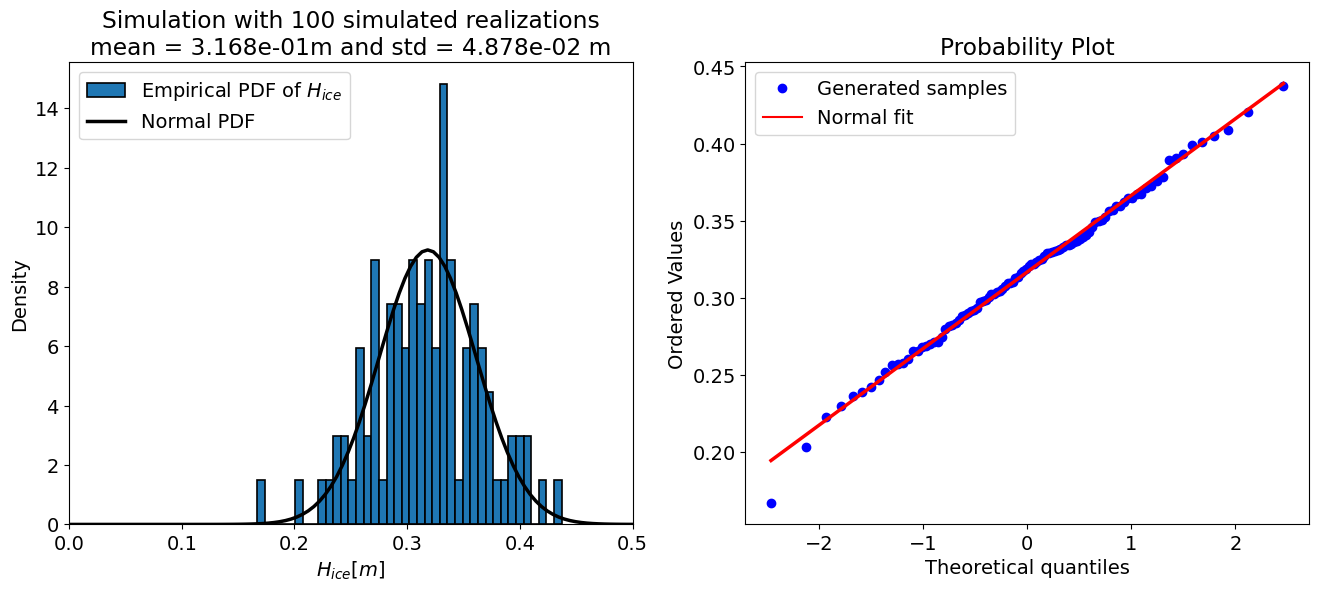

For N = 100 samples:
    mean = 0.317 m
    std = 0.049 m

Number of iT samples adjusted to 0: 2 (0.4% of N)


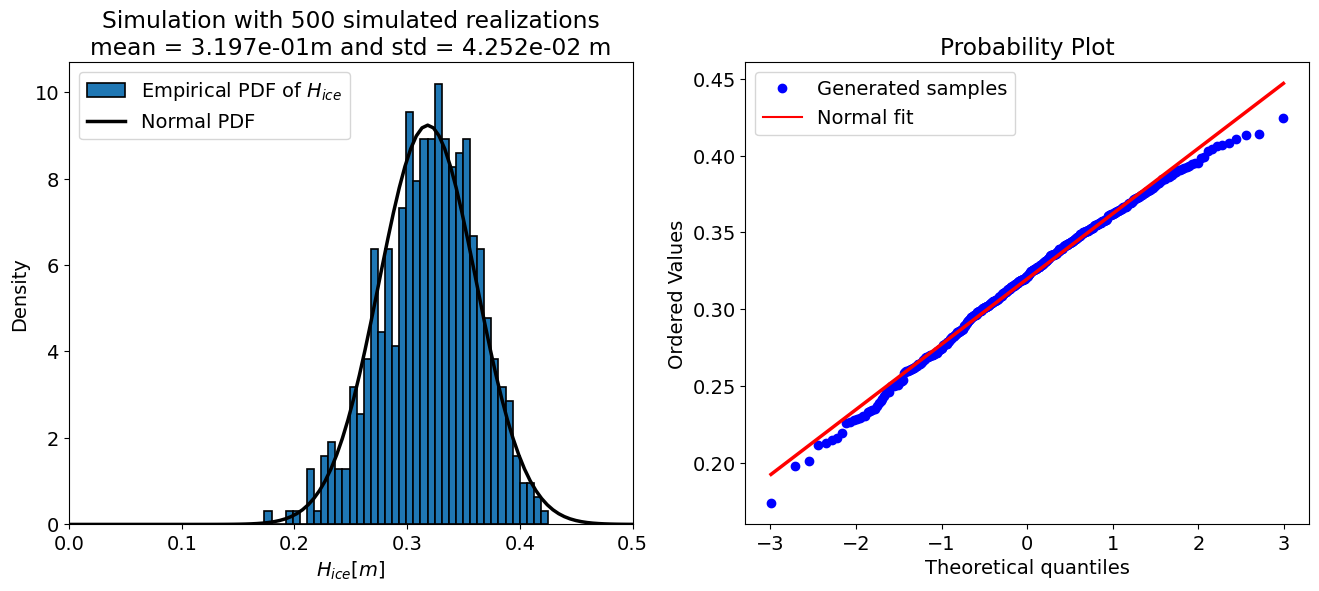

For N = 500 samples:
    mean = 0.320 m
    std = 0.043 m

Number of iT samples adjusted to 0: 64 (0.6% of N)


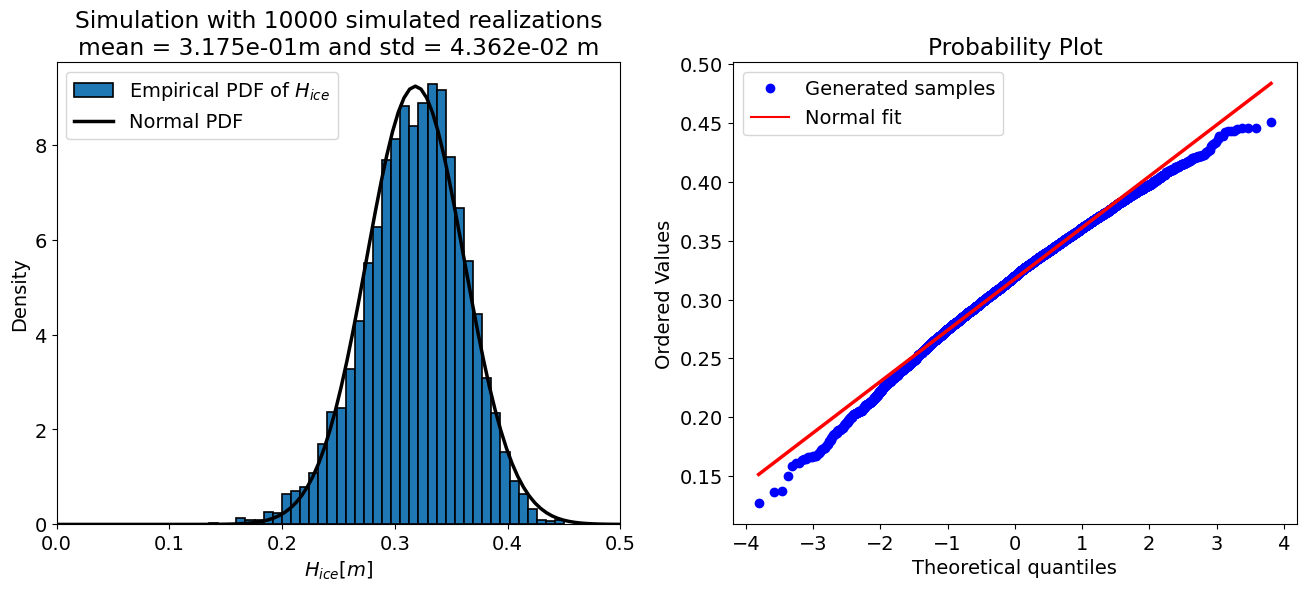

For N = 10000 samples:
    mean = 0.317 m
    std = 0.044 m

Number of iT samples adjusted to 0: 326 (0.7% of N)


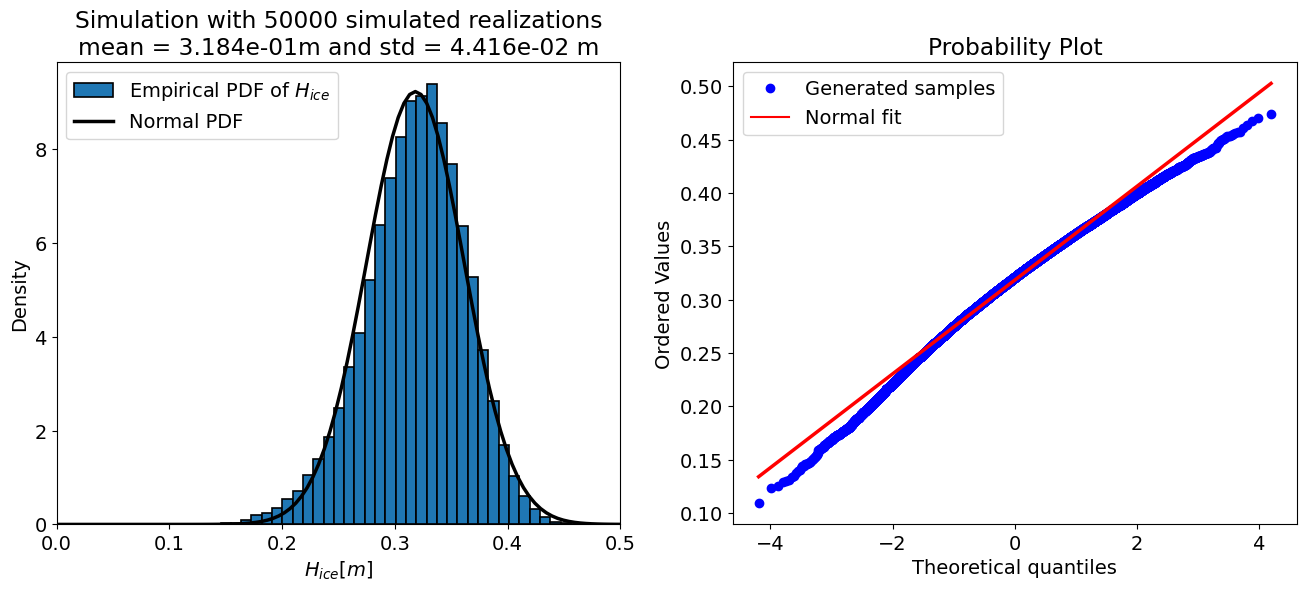

For N = 50000 samples:
    mean = 0.318 m
    std = 0.044 m

Number of iT samples adjusted to 0: 606 (0.6% of N)


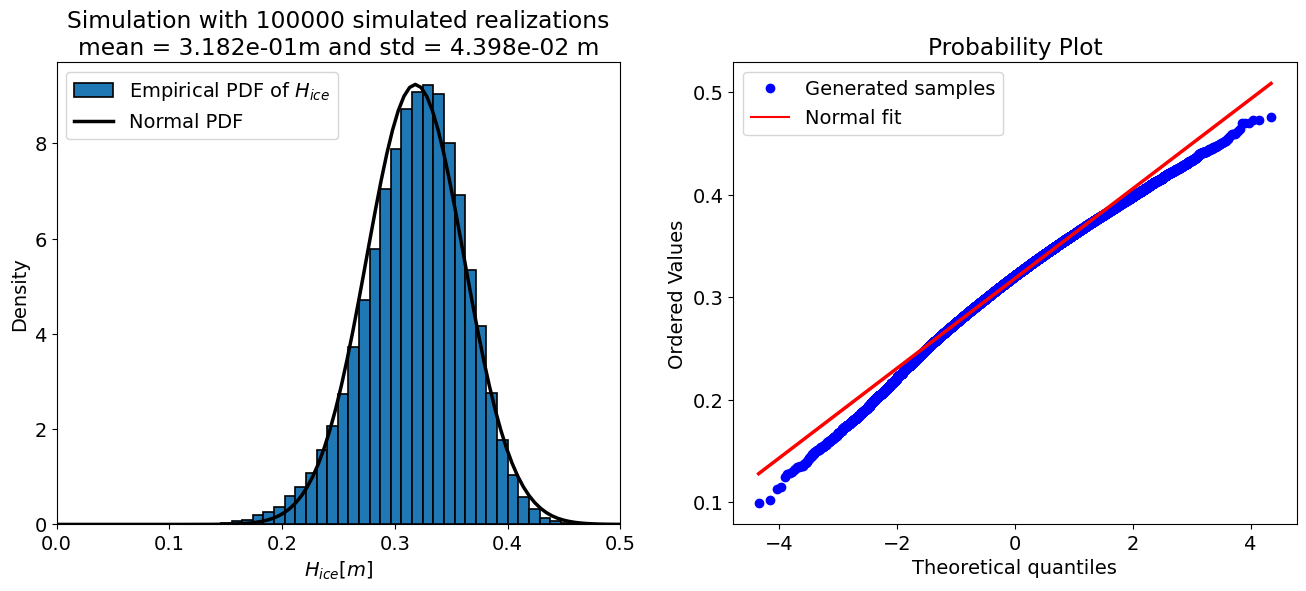

For N = 100000 samples:
    mean = 0.318 m
    std = 0.044 m



In [ ]:
for N in [10, 50, 100, 500, 10000, 50000, 100000]:
    mu_H_simulated, sigma_H_simulated, h_samp = samples_plot(### YOUR CODE HERE ###)
    print(f'For N = {N} samples:')
    print(f'    mean = {mu_H_simulated:.3f} m')
    print(f'    std = {sigma_H_simulated:.3f} m\n')

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 3.2:**
    
Consider now the previous results, and compare the Cumulative Density Function (CDF) based on the "h_samp" produced before. With the following function check how the sample distribution deviates from a fitten normal curve. Answer questions in the Report.

</p>
</div>

In [11]:
# Cumulative Density Function (CDF) comparison
for i in np.linspace(0.1, 0.4, 10):
    print(f'for an ice thickness of {i:5.2f} m --> ' +
          f'{100*sum(h_samp <= i)/len(h_samp):8.4f}% of samples, ' +
          f'{100*norm.cdf(i, mu_H, sigma_H):8.4f}% of distribution')

for an ice thickness of  0.10 m -->   0.0010% of samples,   0.0000% of distribution
for an ice thickness of  0.13 m -->   0.0100% of samples,   0.0009% of distribution
for an ice thickness of  0.17 m -->   0.1330% of samples,   0.0227% of distribution
for an ice thickness of  0.20 m -->   0.8900% of samples,   0.3114% of distribution
for an ice thickness of  0.23 m -->   3.7130% of samples,   2.4766% of distribution
for an ice thickness of  0.27 m -->  12.1260% of samples,  11.6539% of distribution
for an ice thickness of  0.30 m -->  32.0330% of samples,  33.6891% of distribution
for an ice thickness of  0.33 m -->  61.4790% of samples,  63.7034% of distribution
for an ice thickness of  0.37 m -->  87.1750% of samples,  86.9079% of distribution
for an ice thickness of  0.40 m -->  97.9470% of samples,  97.0858% of distribution


<div style="background-color:#F6C78B; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

Once you have completed the analysis in this notebook, proceed to the questions in `Report.md`
    
</p>
</div>

> By Lotfi Massarweh and Sandra Verhagen,, Delft University of Technology. CC BY 4.0, more info on the Credits page of Workbook. 